# Lineages
Natalia Vélez, July 2020

The goal of this notebook is to construct family graphs (directed graph from parent —> child) out of the lifelog data. These family trees will be used in several other analyses.

In [1]:
# %matplotlib inline

import os, re, glob, json, tqdm
import pandas as pd
import numpy as np

import networkx as nx
# import matplotlib.pyplot as plt
# import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

from os.path import join as opj
# from tqdm import notebook
from ast import literal_eval as make_tuple

sns.set_context('talk')
sns.set_style('white')

# Helper function
def gsearch(*args): return glob.glob(opj(*args)) # Search for fukes
def clean_tuple(s):
    try:
        t = make_tuple(s)
    except ValueError:
        t = ()
    return t

Get data from all eras:

In [2]:
era_files = glob.glob('outputs/lifelogs*_data.tsv')
era_list = []

for f in era_files:
    era_data = pd.read_csv(f, sep='\t', index_col=0)
    era_list.append(era_data)
    
era_df = pd.concat(era_list)
era_df = era_df.drop(columns=['server', 'release', 'era'])
# era_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,event,timestamp,avatar,player,age,sex,location,parent,cause_of_death,killer
0,B,1548804597,2,a51edcb77a3900d53adc61d394876c5ca7417486,NaN,F,"(50, -7)",noParent,NaN,NaN
1,D,1548807206,2,a51edcb77a3900d53adc61d394876c5ca7417486,57.49,F,"(64, -8)",NaN,hunger,NaN
2,B,1548814222,3,ba474919bfbe67b14ec6e6fd05c19f383152b1b2,NaN,F,"(1453, -436)",noParent,NaN,NaN
3,B,1548814226,4,0c1781b6944db9e58b5d71adfe64af09fedad796,NaN,M,"(1453, -436)",3,NaN,NaN
4,B,1548814227,5,77a67da50b453a570d1e3311a56cd9da89187cd2,NaN,F,"(1366, -395)",noParent,NaN,NaN


Find players' parents and time/location of birth:

In [3]:
idx_vars = ['player', 'avatar']
births = era_df[era_df['event'] == 'B'].copy()
births = births[idx_vars + ['timestamp', 'parent', 'location']]
births = births.rename({'location': 'birth', 'timestamp': 'tBirth'}, axis='columns')
# births.head()

,player,avatar,tBirth,parent,birth
0,a51edcb77a3900d53adc61d394876c5ca7417486,2,1548804597,noParent,"(50, -7)"
2,ba474919bfbe67b14ec6e6fd05c19f383152b1b2,3,1548814222,noParent,"(1453, -436)"
3,0c1781b6944db9e58b5d71adfe64af09fedad796,4,1548814226,3,"(1453, -436)"
4,77a67da50b453a570d1e3311a56cd9da89187cd2,5,1548814227,noParent,"(1366, -395)"
5,ae87cea72e02d701fbb807b56113e3f7a3d20b83,6,1548814231,5,"(1366, -395)"


Find time and circumstances of death:

In [4]:
deaths =  era_df[era_df['event'] == 'D'].copy()
deaths = deaths[idx_vars + ['timestamp', 'location', 'age', 'cause_of_death']]
deaths = deaths.rename({'location': 'death', 'timestamp': 'tDeath'}, axis='columns')

# deaths.head()

,player,avatar,tDeath,death,age,cause_of_death
1,a51edcb77a3900d53adc61d394876c5ca7417486,2,1548807206,"(64, -8)",57.49,hunger
12,b3a2c99deced24ac11f6b8b10ba49066ca96606d,8,1548814282,"(1387, -433)",0.48,hunger
18,c5c94e5501424d0567c90730f5e2e6ad482a440f,16,1548814301,"(1452, -419)",0.09,disconnect
21,c5c94e5501424d0567c90730f5e2e6ad482a440f,18,1548814310,"(1414, -462)",0.09,disconnect
22,b3a2c99deced24ac11f6b8b10ba49066ca96606d,14,1548814313,"(1431, -428)",0.45,hunger


## Merge births and deaths

**DEBUG:** Unique avatar IDs in births and deaths

In [5]:
# Get unique avatars in each DF
unique_births = np.unique(births['avatar'])
unique_deaths = np.unique(deaths['avatar'])

# How many total unique avatars?
unique_avatars = np.concatenate((unique_births, unique_deaths))
unique_avatars = np.unique(unique_avatars)

# Which avatars are in deaths but not births, and vice versa?
not_in_deaths = np.setdiff1d(unique_births, unique_deaths)
not_in_births = np.setdiff1d(unique_deaths, unique_births)

print('%i unique avatars' % len(unique_avatars))
print('%i in both' % len(np.intersect1d(unique_births, unique_deaths)))
print('%i not in deaths: %s...' % (len(not_in_deaths), not_in_deaths[:5],))
print('%i not in births: %s...' % (len(not_in_births), not_in_births[:5],))

3723924 unique avatars
3714279 in both
9645 not in deaths: [ 221 2850 2851 2852 2937]...
0 not in births: []...


Merge & clean up:

In [6]:
print('Births: %s' % (births.shape,))
print('Deaths: %s' % (deaths.shape,))

life_df = pd.merge(births, deaths, on=idx_vars, how='outer')
print('Merged dataframe: %s' % (life_df.shape,))

# Turn birth/death locations to tuples
print('Birth/death locations...')
life_df['birth'] = life_df['birth'].apply(clean_tuple).apply(np.array)
life_df['death'] = life_df['death'].apply(clean_tuple).apply(np.array)

# Split coordinates
print('Splitting into x/y coords...')
life_df[['birthX', 'birthY']] = pd.DataFrame(life_df['birth'].tolist(),
                                              index=life_df.index)   
life_df[['deathX', 'deathY']] = pd.DataFrame(life_df['death'].tolist(),
                                              index=life_df.index)

# Parse player IDs
print('Parsing player IDs...')
life_df['avatar'] = life_df['avatar'].astype(np.int)

# Parse parent IDs
print('Parsing parents...')
#life_df['parent'] = life_df['parent'].str.extract('(noParent|(?<=parent=)[0-9]+)')
life_df['parent'] = life_df['parent'].str.replace('noParent', '-1')
life_df['parent'] = life_df['parent'].astype(np.int)

# Order from most recent
print('Cleaning up...')
life_df = life_df.sort_values('tBirth', ascending=False)
life_df = life_df.reset_index(drop=True)

Births: (3723924, 5)
Deaths: (3714279, 6)
Merged dataframe: (3723924, 9)
Birth/death locations...
Splitting into x/y coords...
Parsing player IDs...
Parsing parents...
Cleaning up...


In [7]:
print(life_df.shape)
# life_df.tail()

(3723924, 13)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY
3723919,ae87cea72e02d701fbb807b56113e3f7a3d20b83,6,1548814231,5,"[1366, -395]",1.548815e+09,"[1438, -435]",6.46,hunger,1366,-395,1438.0,-435.0
3723920,77a67da50b453a570d1e3311a56cd9da89187cd2,5,1548814227,-1,"[1366, -395]",1.548816e+09,"[1388, -435]",39.76,murdered,1366,-395,1388.0,-435.0
3723921,0c1781b6944db9e58b5d71adfe64af09fedad796,4,1548814226,3,"[1453, -436]",1.548816e+09,"[1390, -436]",26.40,murdered,1453,-436,1390.0,-436.0
3723922,ba474919bfbe67b14ec6e6fd05c19f383152b1b2,3,1548814222,-1,"[1453, -436]",1.548815e+09,"[1442, -419]",21.21,hunger,1453,-436,1442.0,-419.0
3723923,a51edcb77a3900d53adc61d394876c5ca7417486,2,1548804597,-1,"[50, -7]",1.548807e+09,"[64, -8]",57.49,hunger,50,-7,64.0,-8.0


## Parse names

Helper function: Remove from data...

* Roman numerals (including some nonsense ones at high-gen numbers)
* Kin labels? (e.g., SHINA1580640)

In [8]:
def is_roman(s):
    # Checks if string is a "valid" Roman numeral
    # Note this includes some *cough*idiosyncratic*cough* numerals in the OHOL dataset:
    # e.g., CLXLIII => True (but actually nonsense)
    roman_regex  = 'M{0,4}(CM|CD|D?C{0,3})(LXL|XC|XL|L?X{0,3})(IX|IV|V?I{0,3})'
    roman_match = re.match(roman_regex, s)
    
    str_length = len(s)
    match_length = roman_match.span()[1]
    
    return str_length == match_length

def is_kin(s, idx):
    kin_regex = '[A-Z]{0,}[0-9]+'
    kin_match = re.search(kin_regex, s)
    return bool(kin_match) & (idx > 0)

def is_valid(s, idx):
    
    not_roman = not is_roman(s)
    not_kin = not is_kin(s, idx)
    
    return not_roman & not_kin

Find name files:

In [9]:
data_dir = '../../data'
name_files = glob.glob(opj(data_dir, 'publicLifeLogData', 'lifeLog_bigserver2*', '*names.txt'))
name_files.sort()
print('Name files:')
print(*[os.path.basename(f) for f in name_files[:5]], sep='\n')
print('...')

2019_01January_29_Tuesday_names.txt
2019_01January_30_Wednesday_names.txt
2019_01January_31_Thursday_names.txt
2019_02February_01_Friday_names.txt
2019_02February_02_Saturday_names.txt


Iterate over name files and extract names:

In [10]:
name_list = []
re.compile("^([A-Z][0-9]+)+$")

for f in tqdm.tqdm(name_files):
    with open(f, 'r') as handle:
        data_str = handle.read().splitlines()

    data = []
    for s in data_str:
        row_data = s.split() # Split lines
        row_data = [si for idx, si in enumerate(row_data) if is_valid(si, idx)]
        
        if len(row_data) > 3:
            row_data.remove('EVE')
            print('Corrected: %s' % row_data)

        while len(row_data) < 3: 
            row_data.append('')

        name_list.append(row_data)

Corrected: ['386865', 'MOON', 'ROA']
Corrected: ['388702', 'MARTHA', 'LIGHT']
Corrected: ['1240637', 'ALEX', 'CHAN']
Corrected: ['1577563', 'KNIGHT', 'FIERRO']
Corrected: ['1579101', 'LARIAH', 'HANNAM']
Corrected: ['1579766', 'JACKIE', 'WISCOMBE']
Corrected: ['1580507', 'BENJAMIN', 'GIOVANNI']
Corrected: ['3488088', 'PURVIS', 'VERA']
Corrected: ['3497051', 'MICKEAL', 'KELLY']



Assemble into dataframe:

In [11]:
name_df = pd.DataFrame(name_list, columns=['avatar', 'first', 'last'])
name_df['avatar'] = name_df['avatar'].astype(np.int)
# name_df.head()

,avatar,first,last
0,5,EVE,ARK
1,4,SLY,
2,6,FOX,ARK
3,9,EVE,ISA
4,10,TESIA,ISA


Merge with `life_df`:

In [12]:
life_df = pd.merge(life_df, name_df, on='avatar')
# life_df.head()

,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,a12bd25b7ca87b4126ab27e4142ab5136f185e2c,3983348,1613458220,3983322,"[-6583, -188]",1.613462e+09,"[-6592, -192]",60.00,oldAge,-6583,-188,-6592.0,-192.0,KANE,S
1,7bd530ec132a3123bbc64f1a7b99a890a78c710f,3983347,1613458114,3983274,"[-7544, 330]",1.613461e+09,"[-7548, 318]",42.14,hunger,-7544,330,-7548.0,318.0,DIA,JAMESON
2,039241fe1322e3c1877753357f239f0e70218553,3983346,1613458026,3983281,"[-7552, 341]",1.613462e+09,"[-7548, 320]",60.00,oldAge,-7552,341,-7548.0,320.0,JANE,JAMESON
3,6b7abc8753b6a431ed0840d88b2c8f103f933639,3983344,1613458002,3983270,"[-7695, 128]",1.613460e+09,"[-7677, 119]",25.22,hunger,-7695,128,-7677.0,119.0,REX,LODEN
4,c0190e141587c8751a311a41df7183a8d1835262,3983343,1613457977,3983276,"[-7570, 320]",1.613462e+09,"[-7687, 119]",60.00,oldAge,-7570,320,-7687.0,119.0,ADELINE,JAMES


Save `life_df` to file:

In [13]:
print('Saving merged lifelogs...')
life_df.to_csv('outputs/all_lifelogs_compact.tsv', sep='\t')

## Sanity check: How many lineages can we expect?

Spot eves:

In [14]:
eves = life_df[life_df['parent'] < 0].reset_index()
eves.to_csv('outputs/lineage_input_eves.csv', index=False)
print(eves['avatar'][:10])

0    3983313
1    3983028
2    3982895
3    3982886
4    3982796
5    3982795
6    3982277
7    3981962
8    3981665
9    3981653
Name: avatar, dtype: int64


How many eves?

In [15]:
n_eves = eves.shape[0]
n_births = len(life_df)
eve_rate = n_eves/n_births
print('%i Eves out of %i births (%0.2f%%)' % (n_eves, n_births, eve_rate*100))

63787 Eves out of 2161128 births (2.95%)


Eve spawn rate over time (TO-DO: MOVE TO LATER SCRIPT)

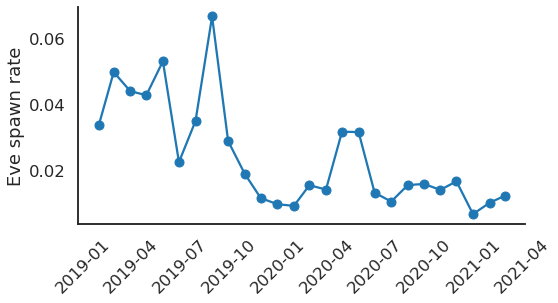

In [16]:
# eve_rate = life_df.copy()
# eve_rate['is_eve'] = eve_rate['parent'] < 0
# eve_rate['date'] = pd.to_datetime(eve_rate['tBirth'],unit='s')
# eve_rate['month'] = eve_rate['date'].dt.to_period('M')

# eve_rate = eve_rate.groupby('month')['is_eve'].agg(['count', 'sum']).reset_index()
# eve_rate = eve_rate.rename(columns={'count': 'n_births', 'sum': 'n_eves'})
# eve_rate['eve_rate'] = eve_rate['n_eves']/eve_rate['n_births']

# fig,ax=plt.subplots(figsize=(8,4))
# ax.plot_date(eve_rate['month'], eve_rate['eve_rate'], '-o')
# ax.set(ylabel='Eve spawn rate')
# plt.xticks(rotation=45)
# sns.despine()

## Parent-child pairs

Helper: Search recursively through lifelogs, starting with Eve

In [23]:
# All parent-child links
parent_df = life_df[['avatar', 'parent']].copy()
parent_df.to_csv('outputs/lineage_input_parents.csv', index=False)
# parent_df.head()

,avatar,parent
0,3983348,3983322
1,3983347,3983274
2,3983346,3983281
3,3983344,3983270
4,3983343,3983276


In [18]:
def search_fam(player):
    descendants = parent_df.loc[parent_df['parent'] == player, 'avatar'].values
    
    for d in descendants:
        descendants = np.append(descendants, search_fam(d))
        
    return descendants

Helper: Write data to JSON file

In [19]:
def write_json(data, f):
    with open(f, 'w') as outfile:
        json.dump(data, outfile)

All parent-child pairs:

Main loop: Build graphs from parent-child pairs:

In [22]:
os.makedirs('outputs/families', exist_ok=True)

families_list = []

for _, family in tqdm.tqdm(eves.iterrows(), total=n_eves):

    eve = family['avatar']
    fam_name = family['last']
    fam_start = family['tBirth']

    fam_nodes = list(search_fam(eve))
    fam_df = parent_df[parent_df['avatar'].isin(fam_nodes)]
    fam = nx.from_pandas_edgelist(fam_df, 'parent', 'avatar', None, nx.DiGraph())    
    fam.add_node(str(eve))

    all_members = fam_nodes + [eve]

    if not len(fam_name):
        fam_name = 'nameless'

    fam_id = 'time-%i_eve-%i_name-%s' % (fam_start, eve, fam_name)

    # Add family to list
    families_list.extend([(relative, fam_id) for relative in all_members])

    # Save family data
    out_file = 'outputs/families/families_%s.json' % fam_id
    fam_data = nx.json_graph.node_link_data(fam)
    write_json(fam_data, out_file)

KeyboardInterrupt: 

### Tag lifelogs by family
This will be used for several subsequent analyses (e.g., migration, comparing different success measures)

In [ ]:
families_df = pd.DataFrame(families_list, columns=['avatar', 'family'])
families_df.to_csv('outputs/family_playerID.tsv', sep='\t')